# Automatic Piano Fingering Detection from Video

**Master's Thesis Project – Sapienza University of Rome**

---

## Project Goal

Given a video of a piano performance with synchronized MIDI data, automatically determine the finger assignment (1–5, thumb to pinky) for each played note.

**Input**: Video + MIDI → **Output**: Per-note finger labels (L1–L5 for left hand, R1–R5 for right hand)

## Pipeline Architecture

```
Video → Keyboard Detection → Hand Processing → Finger-Key Assignment → Neural Refinement → Fingering Labels
         (OpenCV)            (MediaPipe)       (Gaussian Prob.)         (BiLSTM)
```

| Stage | Method | Input | Output |
|-------|--------|-------|--------|
| 1. Keyboard Detection | Corner annotations + Homography | Video frame | 88 key bounding boxes |
| 2. Hand Processing | Hampel + SavGol filters | MediaPipe skeleton JSON | Filtered landmarks (T×21×3) |
| 3. Finger Assignment | Gaussian probability | MIDI events + fingertips + keys | FingerAssignment per note |
| 4. Neural Refinement | BiLSTM + Attention | Initial assignments | Refined predictions |

## Dataset

**PianoVAM** (KAIST) – [HuggingFace](https://huggingface.co/datasets/PianoVAM/PianoVAM_v1.0)
- 107 piano performances with synchronized video, audio, MIDI
- Pre-extracted 21-keypoint hand skeletons (MediaPipe)
- Multiple skill levels: Beginner, Intermediate, Advanced
- Top-view camera angle (1920×1080, 60fps)
- Metadata loaded from `metadata_v1.json`; individual files downloaded on demand

| Split | Samples |
|-------|---------|
| Train | 73 |
| Validation | 19 |
| Test | 14 |

## Table of Contents

0. [Environment Setup](#0)
1. [Data Exploration](#1)
2. [Stage 1: Keyboard Detection](#2)
3. [Stage 2: Hand Processing](#3)
4. [Stage 3: Finger-Key Assignment](#4)
5. [Baseline Pipeline on Multiple Samples](#5)
6. [Stage 4: Neural Refinement (BiLSTM)](#6)
7. [Evaluation & Results](#7)

---
<a id='0'></a>
## 0. Environment Setup

Clone the repository and install dependencies. This cell handles both Colab and local setups.

In [2]:
# ==============================================================================
# 0.1 - Environment Setup
# ==============================================================================
import os, sys, subprocess

IN_COLAB = 'google.colab' in str(get_ipython()) if 'get_ipython' in dir() else False

if IN_COLAB:
    REPO_URL = 'https://github.com/esnylmz/computer-vision.git'
    BRANCH = 'besn2'

    # Clone repository (or reuse existing folder)
    if not os.path.exists('computer-vision'):
        subprocess.run(['git', 'clone', '--branch', BRANCH, '--single-branch', REPO_URL], check=True)

    os.chdir('computer-vision')

    # Make sure we are on the correct branch (in case folder already existed)
    subprocess.run(['git', 'fetch', 'origin', BRANCH], check=True)
    subprocess.run(['git', 'checkout', BRANCH], check=True)
    subprocess.run(['git', 'pull', '--ff-only', 'origin', BRANCH], check=True)

    # Install the project package + extra deps
    subprocess.run([sys.executable, '-m', 'pip', 'install', '-q', '-e', '.'], check=True)
    subprocess.run([sys.executable, '-m', 'pip', 'install', '-q', 'torchcodec'], check=True)

    print("\nColab environment ready")
else:
    # Local development – make sure project root is on path
    PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
    if PROJECT_ROOT not in sys.path:
        sys.path.insert(0, PROJECT_ROOT)
    print("Local environment ready")

# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json, time, warnings
from pathlib import Path
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore', category=UserWarning)
sns.set_style('whitegrid')

print(f"NumPy  : {np.__version__}")
print(f"Pandas : {pd.__version__}")

import torch
print(f"PyTorch: {torch.__version__}")
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device : {DEVICE}")


Colab environment ready
NumPy  : 2.0.2
Pandas : 2.2.2
PyTorch: 2.9.0+cpu
Device : cpu


In [3]:
# ==============================================================================
# 0.2 - Import Project Modules
# ==============================================================================
from src.data.dataset import PianoVAMDataset, PianoVAMSample
from src.data.midi_utils import MidiProcessor, MidiEvent
from src.data.video_utils import VideoProcessor
from src.utils.config import load_config, Config

from src.keyboard.detector import KeyboardDetector, KeyboardRegion
from src.keyboard.homography import HomographyComputer
from src.keyboard.key_localization import KeyLocalizer

from src.hand.skeleton_loader import SkeletonLoader, HandLandmarks
from src.hand.temporal_filter import TemporalFilter
from src.hand.fingertip_extractor import FingertipExtractor, FingertipData

from src.assignment.gaussian_assignment import GaussianFingerAssigner, FingerAssignment
from src.assignment.midi_sync import MidiVideoSync
from src.assignment.hand_separation import HandSeparator

from src.refinement.model import FingeringRefiner, FeatureExtractor, SequenceDataset
from src.refinement.constraints import BiomechanicalConstraints
from src.refinement.decoding import constrained_viterbi_decode
from src.refinement.train import train_refiner, collate_fn

from src.evaluation.metrics import FingeringMetrics, EvaluationResult, aggregate_results
from src.evaluation.visualization import ResultVisualizer

from src.pipeline import FingeringPipeline

# Load configuration (use colab config when on Colab)
config_path = 'configs/colab.yaml' if IN_COLAB else 'configs/default.yaml'
config = load_config(config_path)
print(f"All modules imported | Config: {config_path}")
print(f"Project: {config.project_name} v{config.version}")

All modules imported | Config: configs/colab.yaml
Project: piano-fingering-detection v1.0.0


---
<a id='1'></a>
## 1. Data Exploration

Load the PianoVAM dataset from HuggingFace and explore its structure.

**How it works**: We download `metadata_v1.json` (~15 KB) from the HuggingFace repo, which
contains all sample metadata (composer, piece, skill level, keyboard corners, etc.).
Individual files (skeleton JSON, TSV annotations, video, audio) are downloaded on demand.
No bulk download of the full dataset (~7 GB) is needed.

In [4]:
# ==============================================================================
# 1.1 - Load Dataset Splits
# ==============================================================================
# PianoVAMDataset downloads metadata_v1.json (~15 KB) from HuggingFace,
# then filters by the 'split' column:
#   train: 73  |  valid: 19  |  test: 14
# No audio/video is downloaded here — only metadata.
# ==============================================================================

MAX_EXPLORE = 20  # metadata-only; increase as needed

print("Loading PianoVAM dataset splits (streaming mode)...\n")

train_dataset = PianoVAMDataset(split='train', streaming=True, max_samples=MAX_EXPLORE)
print("  Train split ready")

val_dataset = PianoVAMDataset(split='validation', streaming=True, max_samples=MAX_EXPLORE)
print("  Validation split ready")

test_dataset = PianoVAMDataset(split='test', streaming=True, max_samples=MAX_EXPLORE)
print("  Test split ready")

print("\nAll splits loaded (streaming – no bulk download).")

Loading PianoVAM dataset splits (streaming mode)...

  ✅ Loaded 20 'train' samples
  Train split ready
  ✅ Loaded 19 'valid' samples
  Validation split ready
  ✅ Loaded 14 'test' samples
  Test split ready

All splits loaded (streaming – no bulk download).


In [5]:
# ==============================================================================
# 1.2 - Verify & Preview Samples
# ==============================================================================

for name, ds in [('Train', train_dataset), ('Validation', val_dataset), ('Test', test_dataset)]:
    try:
        s = next(iter(ds))
        print(f"OK {name:12s} | ID={s.id:>4s}  Composer={s.metadata['composer']:<20s}  "
              f"Piece={s.metadata['piece']:<30s}  Skill={s.metadata['skill_level']}")
    except StopIteration:
        print(f"EMPTY {name:12s}")

OK Train        | ID=2024-02-14_19-10-09  Composer=E. Grieg              Piece=Piano Concerto                  Skill=Advanced
OK Validation   | ID=2024-02-15_20-07-54  Composer=F. Chopin             Piece=Grande Valse Brillante, Op.18   Skill=Intermediate
OK Test         | ID=2024-02-14_19-55-17  Composer=C. Saint-Saëns        Piece=Piano Concerto No.2             Skill=Advanced


In [6]:
# ==============================================================================
# 1.3 - Explore a Single Sample in Detail
# ==============================================================================

sample = next(iter(train_dataset))

print(f"Sample ID      : {sample.id}")
print(f"Composer       : {sample.metadata['composer']}")
print(f"Piece          : {sample.metadata['piece']}")
print(f"Performer      : {sample.metadata['performer']}")
print(f"Skill Level    : {sample.metadata['skill_level']}")
print(f"Duration       : {sample.metadata.get('duration', 'N/A')}s")
print(f"\nKeyboard Corners: {sample.metadata['keyboard_corners']}")
print(f"\nFile URLs:")
print(f"  Video    : {sample.video_path[:90]}...")
print(f"  MIDI     : {sample.midi_path[:90]}...")
print(f"  Skeleton : {sample.skeleton_path[:90]}...")
print(f"  TSV      : {sample.tsv_path[:90]}...")

Sample ID      : 2024-02-14_19-10-09
Composer       : E. Grieg
Piece          : Piano Concerto
Performer      : Yonghyun
Skill Level    : Advanced
Duration       : 0 days 00:12:25.493.000000s

Keyboard Corners: {'LT': (121, 355), 'RT': (1839, 345), 'RB': (1839, 558), 'LB': (120, 564)}

File URLs:
  Video    : https://huggingface.co/datasets/PianoVAM/PianoVAM_v1.0/resolve/main/Video/2024-02-14_19-10...
  MIDI     : https://huggingface.co/datasets/PianoVAM/PianoVAM_v1.0/resolve/main/MIDI/2024-02-14_19-10-...
  Skeleton : https://huggingface.co/datasets/PianoVAM/PianoVAM_v1.0/resolve/main/Handskeleton/2024-02-1...
  TSV      : https://huggingface.co/datasets/PianoVAM/PianoVAM_v1.0/resolve/main/TSV/2024-02-14_19-10-0...


  ✅ Loaded 73 'train' samples


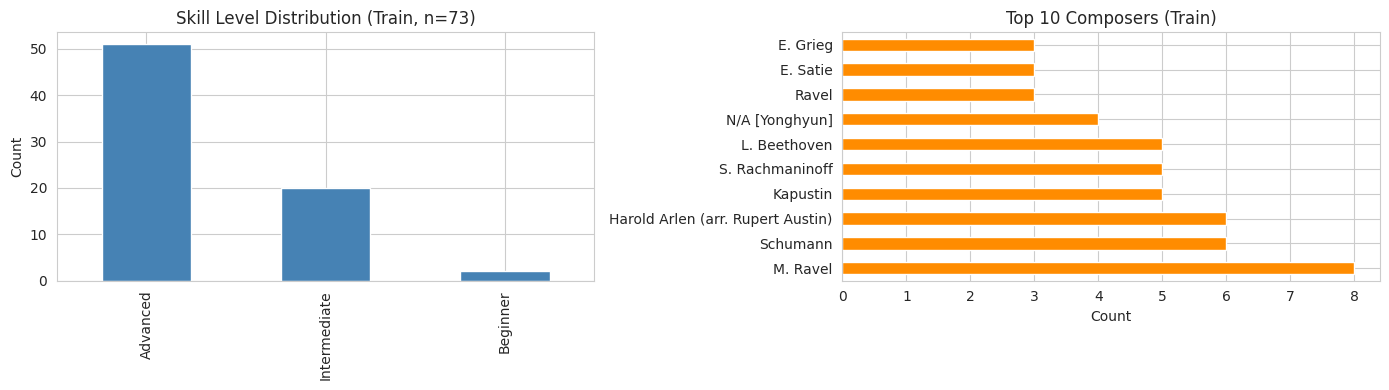


Train samples    : 73
Unique composers : 31
Unique pieces    : 35
Skill levels     : {'Advanced': np.int64(51), 'Intermediate': np.int64(20), 'Beginner': np.int64(2)}


In [7]:
# ==============================================================================
# 1.4 - Dataset Statistics (Full Train Split)
# ==============================================================================
# Load all 73 train samples (metadata only – no audio/video download).
# ==============================================================================

print("Collecting dataset statistics from full train split ...")
stats_ds = PianoVAMDataset(split='train', max_samples=None)

composers, skill_levels, pieces = [], [], []
for s in stats_ds:
    composers.append(s.metadata['composer'])
    skill_levels.append(s.metadata['skill_level'])
    pieces.append(s.metadata['piece'])

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Skill level distribution
pd.Series(skill_levels).value_counts().plot.bar(ax=axes[0], color='steelblue')
axes[0].set_title(f'Skill Level Distribution (Train, n={len(skill_levels)})')
axes[0].set_ylabel('Count')

# Composer distribution (top 10)
comp_counts = pd.Series(composers).value_counts().head(10)
comp_counts.plot.barh(ax=axes[1], color='darkorange')
axes[1].set_title('Top 10 Composers (Train)')
axes[1].set_xlabel('Count')

plt.tight_layout()
plt.show()

print(f"\nTrain samples    : {len(skill_levels)}")
print(f"Unique composers : {len(set(composers))}")
print(f"Unique pieces    : {len(set(pieces))}")
print(f"Skill levels     : {dict(pd.Series(skill_levels).value_counts())}")

---
<a id='2'></a>
## 2. Stage 1 – Keyboard Detection

**Goal**: Detect piano key boundaries from corner annotations.

PianoVAM provides 4-point corner annotations (`Point_LT`, `Point_RT`, `Point_RB`, `Point_LB`). We use these to:
1. Compute a homography matrix for perspective normalization.
2. Map all 88 keys to pixel bounding boxes.

In [8]:
# ==============================================================================
# 2.1 - Detect Keyboard from Corner Annotations
# ==============================================================================

sample = next(iter(train_dataset))
corners = sample.metadata['keyboard_corners']
print(f"Sample: {sample.id}  |  Corners: {corners}")

# Initialize detector
detector = KeyboardDetector({
    'canny_low': config.keyboard.canny_low,
    'canny_high': config.keyboard.canny_high,
    'hough_threshold': config.keyboard.hough_threshold
})

# Use corner-based detection (preferred when annotations are available)
keyboard_region = detector.detect_from_corners(corners)

print("\nKeyboard detected")
print(f"   Bounding box    : {keyboard_region.bbox}")
print(f"   Keys localised  : {len(keyboard_region.key_boundaries)}")
print(f"   White key width : {keyboard_region.white_key_width:.1f} px")
print(f"   Black key width : {keyboard_region.black_key_width:.1f} px")
print(f"   Homography shape: {keyboard_region.homography.shape}")

Sample: 2024-02-14_19-10-09  |  Corners: {'LT': (121, 355), 'RT': (1839, 345), 'RB': (1839, 558), 'LB': (120, 564)}

Keyboard detected
   Bounding box    : (120, 345, 1839, 564)
   Keys localised  : 88
   White key width : 33.0 px
   Black key width : 19.8 px
   Homography shape: (3, 3)


White keys: 52  |  Black keys: 36


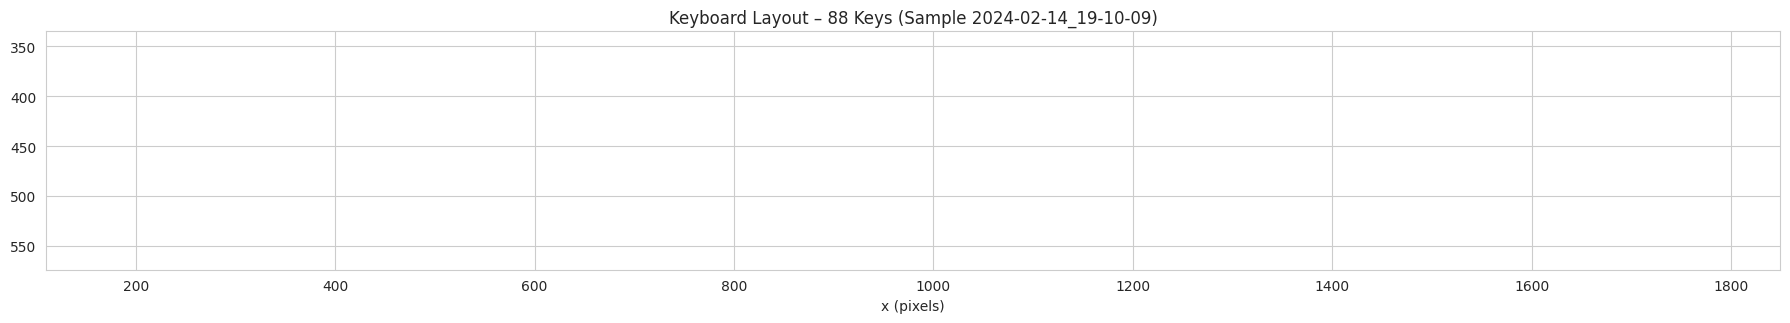

In [9]:
# ==============================================================================
# 2.2 - Visualise Key Boundaries
# ==============================================================================

localizer = KeyLocalizer(keyboard_region.key_boundaries)

# Gather key info
white_keys = localizer.get_white_keys()
black_keys = localizer.get_black_keys()

print(f"White keys: {len(white_keys)}  |  Black keys: {len(black_keys)}")

# Plot key layout
fig, ax = plt.subplots(figsize=(18, 3))

for ki in white_keys:
    x1, y1, x2, y2 = ki.bbox
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=0.8,
                          edgecolor='black', facecolor='white')
    ax.add_patch(rect)

for ki in black_keys:
    x1, y1, x2, y2 = ki.bbox
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=0.5,
                          edgecolor='black', facecolor='#333333')
    ax.add_patch(rect)

# Mark some reference keys
for note_name in ['A0', 'C4', 'C8']:
    ki = localizer.get_key_by_name(note_name)
    if ki:
        ax.annotate(ki.note_name, xy=ki.center, fontsize=7, color='red',
                    ha='center', va='bottom')

ax.set_xlim(keyboard_region.bbox[0] - 10,
            keyboard_region.bbox[2] + 10)
ax.set_ylim(keyboard_region.bbox[3] + 10,
            keyboard_region.bbox[1] - 10)
ax.set_aspect('equal')
ax.set_title(f'Keyboard Layout – 88 Keys (Sample {sample.id})')
ax.set_xlabel('x (pixels)')
plt.tight_layout()
plt.show()

In [10]:
# ==============================================================================
# 2.3 - Homography Demonstration
# ==============================================================================

homography_computer = HomographyComputer()

# If real corners are available, compute homography
if keyboard_region.corners:
    H = homography_computer.compute_from_corners(keyboard_region.corners)
    print(f"Homography matrix:\n{H}")

    # Show how a point transforms
    test_point = keyboard_region.corners.get('LT', (0, 0))
    warped = homography_computer.warp_point(test_point, H)
    print(f"\nCorner LT {test_point} -> normalised {warped}")
else:
    print("Corner annotations not parsed as tuples; using homography from bbox.")
    H = keyboard_region.homography
    print(f"Homography matrix:\n{H}")

Homography matrix:
[[ 7.61140978e-01  3.64182286e-03 -9.33909054e+01]
 [ 4.46931513e-03  7.67828339e-01 -2.73119847e+02]
 [ 1.11929684e-05  2.84517411e-06  1.00000000e+00]]

Corner LT (121, 355) -> normalised (1.4177334233347362e-14, 0.0)


---
<a id='3'></a>
## 3. Stage 2 – Hand Processing

**Goal**: Load pre-extracted MediaPipe 21-keypoint skeletons, apply temporal filtering, extract fingertip positions.

Filtering pipeline:
1. **Hampel filter** (window=20) – outlier detection via Median Absolute Deviation
2. **Linear interpolation** – fill gaps < 30 frames
3. **Savitzky-Golay filter** (window=11, order=3) – smooth high-frequency noise

In [11]:
# ==============================================================================
# 3.1 - Download & Load Skeleton Data
# ==============================================================================

print(f"Downloading skeleton for sample {sample.id} ...")
skeleton_data = train_dataset.load_skeleton(sample)

# Inspect structure
print(f"\nSkeleton data type : {type(skeleton_data).__name__}")
if isinstance(skeleton_data, dict):
    print(f"Top-level keys     : {list(skeleton_data.keys())[:10]}")
elif isinstance(skeleton_data, list):
    print(f"Number of frames   : {len(skeleton_data)}")
    if skeleton_data:
        print(f"First frame keys   : {list(skeleton_data[0].keys()) if isinstance(skeleton_data[0], dict) else type(skeleton_data[0]).__name__}")

2024-02-14_19-10-09.json: 100%|██████████| 119M/119M [00:02<00:00, 50.3MB/s]



Skeleton data type : dict
Top-level keys     : ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [12]:
# ==============================================================================
# 3.2 - Parse Skeleton into Arrays
# ==============================================================================

loader = SkeletonLoader()
hands = loader._parse_json(skeleton_data)

print(f"Left  hand frames with data: {len(hands['left'])}")
print(f"Right hand frames with data: {len(hands['right'])}")

left_raw  = loader.to_array(hands['left'])
right_raw = loader.to_array(hands['right'])

print(f"\nLeft  landmarks shape : {left_raw.shape}")
print(f"Right landmarks shape : {right_raw.shape}")

# Count valid frames (non-NaN) – guard against empty arrays
if left_raw.size > 0:
    left_valid = int(np.sum(~np.any(np.isnan(left_raw.reshape(len(left_raw), -1)), axis=1)))
else:
    left_valid = 0

if right_raw.size > 0:
    right_valid = int(np.sum(~np.any(np.isnan(right_raw.reshape(len(right_raw), -1)), axis=1)))
else:
    right_valid = 0

print(f"\nValid frames – Left: {left_valid}  Right: {right_valid}")

Left  hand frames with data: 43228
Right hand frames with data: 42916

Left  landmarks shape : (44731, 21, 3)
Right landmarks shape : (44731, 21, 3)

Valid frames – Left: 43228  Right: 42916


In [13]:
# ==============================================================================
# 3.3 - Temporal Filtering
# ==============================================================================

temporal_filter = TemporalFilter(
    hampel_window=config.hand.hampel_window,
    hampel_threshold=config.hand.hampel_threshold,
    max_interpolation_gap=config.hand.interpolation_max_gap,
    savgol_window=config.hand.savgol_window,
    savgol_order=config.hand.savgol_order
)

print("Applying temporal filtering ...")
if left_raw.size > 0 and left_raw.shape[0] > 0:
    left_filtered = temporal_filter.process(left_raw)
    print(f"  Left  hand filtered: {left_filtered.shape}")
else:
    left_filtered = left_raw
    print("  Left  hand: no data to filter")

if right_raw.size > 0 and right_raw.shape[0] > 0:
    right_filtered = temporal_filter.process(right_raw)
    print(f"  Right hand filtered: {right_filtered.shape}")
else:
    right_filtered = right_raw
    print("  Right hand: no data to filter")

Applying temporal filtering ...
  Left  hand filtered: (44731, 21, 3)
  Right hand filtered: (44731, 21, 3)


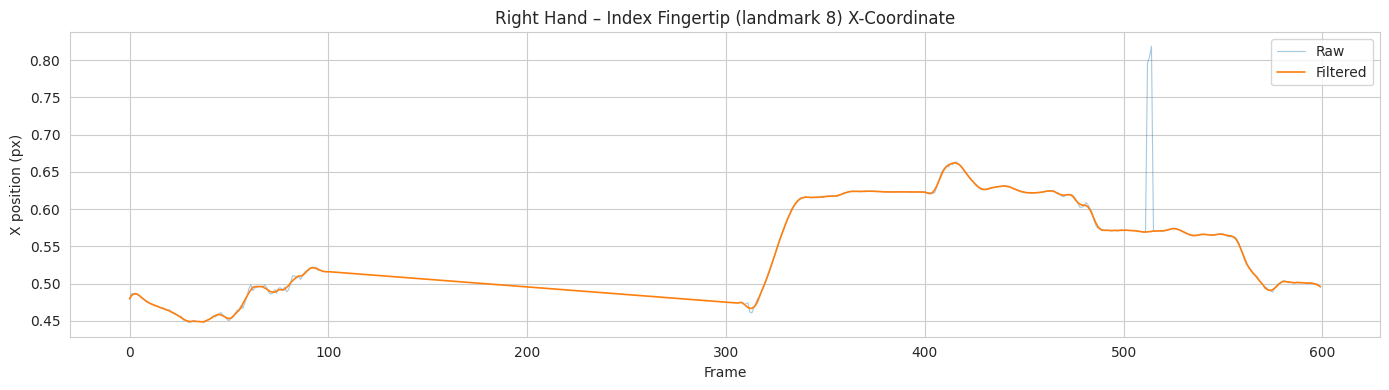

In [14]:
# ==============================================================================
# 3.4 - Visualise Filtering Effect (Index Fingertip X-Coordinate)
# ==============================================================================

# Pick the hand with more data
if right_raw.shape[0] >= left_raw.shape[0] and right_raw.size > 0:
    raw_data, filt_data, hand_label = right_raw, right_filtered, 'Right'
else:
    raw_data, filt_data, hand_label = left_raw, left_filtered, 'Left'

LM_IDX = 8  # Index finger tip
COORD  = 0  # X-coordinate
MAX_FRAMES = min(600, len(raw_data))

fig, ax = plt.subplots(figsize=(14, 4))
frames = np.arange(MAX_FRAMES)
ax.plot(frames, raw_data[:MAX_FRAMES, LM_IDX, COORD],
        alpha=0.4, label='Raw', linewidth=0.8)
ax.plot(frames, filt_data[:MAX_FRAMES, LM_IDX, COORD],
        label='Filtered', linewidth=1.2)
ax.set_xlabel('Frame')
ax.set_ylabel('X position (px)')
ax.set_title(f'{hand_label} Hand – Index Fingertip (landmark 8) X-Coordinate')
ax.legend()
plt.tight_layout()
plt.show()

In [15]:
# ==============================================================================
# 3.5 - Fingertip Extraction
# ==============================================================================

extractor = FingertipExtractor()

right_fingertips = extractor.extract_sequence(right_filtered, hand_type='right')
left_fingertips  = extractor.extract_sequence(left_filtered, hand_type='left')

print(f"Right fingertip data points : {len(right_fingertips)}")
print(f"Left  fingertip data points : {len(left_fingertips)}")

# Show one frame
if right_fingertips:
    ft = right_fingertips[0]
    print(f"\nSample fingertip data (frame {ft.frame_idx}, {ft.hand_type} hand):")
    finger_names = {1: 'Thumb', 2: 'Index', 3: 'Middle', 4: 'Ring', 5: 'Pinky'}
    for fnum, pos in ft.positions.items():
        print(f"  {finger_names[fnum]:6s} : ({pos[0]:.1f}, {pos[1]:.1f})")

Right fingertip data points : 44731
Left  fingertip data points : 44731

Sample fingertip data (frame 0, right hand):
  Thumb  : (0.5, 0.5)
  Index  : (0.5, 0.4)
  Middle : (0.5, 0.4)
  Ring   : (0.5, 0.4)
  Pinky  : (0.5, 0.4)


---
<a id='4'></a>
## 4. Stage 3 – Finger-Key Assignment

**Goal**: Synchronise MIDI note events with video frames and assign fingers to pressed keys using a Gaussian probability model.

$$P(\text{finger}_i \rightarrow \text{key}_k) = \exp\left(-\frac{(\Delta x_{ik})^2}{2\sigma^2}\right)$$

where $\Delta x_{ik}$ is the **horizontal (x-only) pixel distance** from fingertip $i$ to key centre $k$.

> **Why pixel space & x-only?** The keyboard homography correctly maps the key *surface* but distorts hand landmarks floating *above* it (parallax). We avoid this by projecting key centres back to image-pixel space via $H^{-1}$ and comparing with landmarks scaled to pixels. The y-axis measures key depth and varies systematically with finger length, so only the x-component (along the keyboard) is used.

In [16]:
# ==============================================================================
# 4.1 - Load & Parse MIDI / TSV Annotations
# ==============================================================================

# Download TSV (contains onset, key_offset, frame_offset, note, velocity)
print(f"Downloading TSV annotations for sample {sample.id} ...")
tsv_df = train_dataset.load_tsv_annotations(sample)

print(f"\nTSV shape: {tsv_df.shape}")
print(tsv_df.head(10))

# Convert to MIDI event dicts for our pipeline
midi_events = []
for _, row in tsv_df.iterrows():
    midi_events.append({
        'onset': float(row['onset']),
        'offset': float(row['onset']) + 0.3,  # approximate offset
        'pitch': int(row['note']),
        'velocity': int(row['velocity']) if 'velocity' in row and pd.notna(row['velocity']) else 64
    })

print(f"\nTotal MIDI events: {len(midi_events)}")
print(f"Pitch range: {min(e['pitch'] for e in midi_events)} – {max(e['pitch'] for e in midi_events)}")
print(f"Time range : {midi_events[0]['onset']:.2f}s – {midi_events[-1]['onset']:.2f}s")

2024-02-14_19-10-09.tsv: 268kB [00:00, 7.15MB/s]


TSV shape: (6935, 5)
      onset  key_offset  frame_offset  note  velocity
0  6.684375    6.740625      6.740625   105        92
1  6.685417    6.735417      6.735417    96        87
2  6.688542    6.730208      6.730208   100        91
3  6.691667    7.818750      8.382292    69        77
4  6.692708    6.720833      6.720833    93        93
5  6.694792    7.817708      8.382292    81        95
6  6.702083    6.759375      8.382292    76        85
7  6.718750    6.758333      8.382292    72        64
8  7.807292    7.861458      8.382292    93        93
9  7.809375    7.865625      8.382292   105        92

Total MIDI events: 6935
Pitch range: 21 – 107
Time range : 6.68s – 738.54s


In [17]:
# ==============================================================================
# 4.2 - MIDI-Video Synchronisation
# ==============================================================================

midi_sync = MidiVideoSync(fps=config.video_fps)
synced_events = midi_sync.sync_events(midi_events)

print(f"Synced events: {len(synced_events)}")
print(f"\nFirst 5 events:")
for ev in synced_events[:5]:
    print(f"  Frame {ev.frame_idx:>5d}  |  {ev.note_name:4s}  "
          f"(MIDI {ev.midi_pitch})  |  key_idx {ev.key_idx}  |  vel {ev.velocity}")

Synced events: 6935

First 5 events:
  Frame   401  |  A7    (MIDI 105)  |  key_idx 84  |  vel 92
  Frame   401  |  C7    (MIDI 96)  |  key_idx 75  |  vel 87
  Frame   401  |  E7    (MIDI 100)  |  key_idx 79  |  vel 91
  Frame   401  |  A4    (MIDI 69)  |  key_idx 48  |  vel 77
  Frame   401  |  A6    (MIDI 93)  |  key_idx 72  |  vel 93


In [18]:
# ==============================================================================
# 4.3 - Gaussian Finger Assignment
# ==============================================================================
# STRATEGY: work in IMAGE-PIXEL space, NOT keyboard-homography space.
#
# The homography correctly maps points on the keyboard SURFACE but distorts
# hand landmarks that float ABOVE it (parallax error).  This caused the
# thumb (shortest finger) to appear closest to every key in the warped view.
#
# Fix:
#   1. Project key centres from warped space BACK to pixel space (H⁻¹)
#   2. Scale landmarks from [0,1] to pixels (simple multiplication)
#   3. Compare in pixel space using x-distance only
#
# Why x-only?  In a top-down piano view the y-axis measures depth into the
# keyboard.  It varies with finger length and carries no useful signal.
# σ auto-scales to the mean key width when config.assignment.sigma is None.
# ==============================================================================

FRAME_W, FRAME_H = 1920, 1080  # PianoVAM video resolution


def project_keys_to_pixel_space(key_boundaries_warped, homography):
    """
    Project key bounding boxes from warped (rectified) space back to
    original image-pixel space using the inverse homography.

    The inverse transform is exact for key centres (which lie ON the
    keyboard plane), so pixel-space distances between keys and hands
    are free of the parallax bias that affects the forward warp.
    """
    H_inv = np.linalg.inv(homography)

    result = {}
    for k, (x1, y1, x2, y2) in key_boundaries_warped.items():
        cy = (y1 + y2) / 2.0
        # Three points at key mid-height: left edge, right edge, centre
        pts_w = np.array([[x1, cy, 1.0],
                          [x2, cy, 1.0],
                          [(x1 + x2) / 2.0, cy, 1.0]], dtype=np.float64)
        pts_p = (H_inv @ pts_w.T).T           # (3, 3)
        pts_p = pts_p[:, :2] / pts_p[:, 2:3]  # dehomogenise

        lx, rx = pts_p[0, 0], pts_p[1, 0]
        cy_px  = pts_p[2, 1]
        result[k] = (lx, cy_px - 5.0, rx, cy_px + 5.0)

    return result


# --- Project key boundaries into pixel space ---
key_boundaries_px = project_keys_to_pixel_space(
    keyboard_region.key_boundaries, keyboard_region.homography
)

# --- Scale landmarks from [0,1] → pixels (NO homography warp!) ---
left_px  = left_filtered.copy()
left_px[:, :, 0] *= FRAME_W
left_px[:, :, 1] *= FRAME_H

right_px = right_filtered.copy()
right_px[:, :, 0] *= FRAME_W
right_px[:, :, 1] *= FRAME_H

# --- Initialise assigner with pixel-space keys ---
assigner = GaussianFingerAssigner(
    key_boundaries=key_boundaries_px,
    sigma=config.assignment.sigma,          # None → auto-scale to key width
    candidate_range=config.assignment.candidate_keys
)

# Sanity check: coordinate ranges
key_xs = [c[0] for c in assigner.key_centers.values()]
print(f"Key centres  x: [{min(key_xs):.0f} .. {max(key_xs):.0f}] px")
if right_px.size > 0:
    print(f"Right hand   x: [{np.nanmin(right_px[:,:,0]):.0f} .. {np.nanmax(right_px[:,:,0]):.0f}] px")
if left_px.size > 0:
    print(f"Left  hand   x: [{np.nanmin(left_px[:,:,0]):.0f} .. {np.nanmax(left_px[:,:,0]):.0f}] px")
print(f"σ (auto)     : {assigner.sigma:.1f} px  (≈ 1 key width in image)")
print(f"Max distance : {assigner.max_distance_px:.0f} px  ({assigner.max_distance_sigma}σ – reject if no finger closer)")
print(f"Distance mode: x-only (horizontal along keyboard)")
print(f"Confidence   : raw Gaussian prob (not normalised)")
print(f"Hand select  : try BOTH hands, pick higher confidence")
print(f"→ Both keys & hands in image-pixel space (no warp on hands).\n")

# Run assignment on all synced events.
# Strategy: try BOTH hands for every key, pick the one with higher
# confidence (= raw Gaussian probability = closer fingertip).
# The max-distance gate inside the assigner returns None when the
# hand is clearly not near the key, so bad assignments are rejected.
assignments = []
skipped = 0

for event in synced_events:
    frame_idx = event.frame_idx
    key_idx = event.key_idx

    if key_idx not in assigner.key_centers:
        skipped += 1
        continue

    # Try right hand
    asgn_right = None
    if frame_idx < len(right_px):
        lm = right_px[frame_idx]
        if not np.any(np.isnan(lm)):
            asgn_right = assigner.assign_from_landmarks(
                lm, key_idx, 'right', frame_idx, event.onset_time)

    # Try left hand
    asgn_left = None
    if frame_idx < len(left_px):
        lm = left_px[frame_idx]
        if not np.any(np.isnan(lm)):
            asgn_left = assigner.assign_from_landmarks(
                lm, key_idx, 'left', frame_idx, event.onset_time)

    # Pick the better assignment (higher raw confidence = closer finger)
    candidates = [a for a in (asgn_right, asgn_left) if a is not None]
    if candidates:
        assignment = max(candidates, key=lambda a: a.confidence)
        assignments.append(assignment)
    else:
        skipped += 1

print("Assignments completed")
print(f"   Total events     : {len(synced_events)}")
print(f"   Assigned         : {len(assignments)}")
print(f"   Skipped (no data): {skipped}")
print(f"   Coverage         : {len(assignments)/max(1,len(synced_events))*100:.1f}%")

# Diagnostic: show fingertip x-positions for first few events
print("\nDiagnostic – fingertip x vs key centre (pixel space):")
for a in assignments[:5]:
    f = a.frame_idx
    hand_arr = right_px if a.hand == 'right' else left_px
    if f < len(hand_arr):
        lm = hand_arr[f]
        tip_x = {fn: lm[idx, 0] for fn, idx in [(1,4),(2,8),(3,12),(4,16),(5,20)]}
        kx = assigner.key_centers[a.key_idx][0]
        dists = " ".join(f"F{fn}:{abs(tip_x[fn]-kx):>4.0f}" for fn in range(1, 6))
        print(f"  Frame {f:>5d} | key_x={kx:>7.0f} | dx: {dists} → {a.finger_name}(F{a.assigned_finger})")

Key centres  x: [137 .. 1822] px
Right hand   x: [-25 .. 1909] px
Left  hand   x: [206 .. 1987] px
σ (auto)     : 27.6 px  (≈ 1 key width in image)
Max distance : 111 px  (4.0σ – reject if no finger closer)
Distance mode: x-only (horizontal along keyboard)
Confidence   : raw Gaussian prob (not normalised)
Hand select  : try BOTH hands, pick higher confidence
→ Both keys & hands in image-pixel space (no warp on hands).

Assignments completed
   Total events     : 6935
   Assigned         : 6881
   Skipped (no data): 54
   Coverage         : 99.2%

Diagnostic – fingertip x vs key centre (pixel space):
  Frame   401 | key_x=   1754 | dx: F1: 220 F2: 156 F3: 105 F4:  52 F5:  14 → pinky(F5)
  Frame   401 | key_x=   1586 | dx: F1:  53 F2:  12 F3:  63 F4: 116 F5: 154 → index(F2)
  Frame   401 | key_x=   1653 | dx: F1: 120 F2:  55 F3:   4 F4:  49 F5:  87 → middle(F3)
  Frame   401 | key_x=   1054 | dx: F1: 239 F2: 140 F3:  66 F4:  42 F5:   4 → pinky(F5)
  Frame   401 | key_x=   1520 | dx: F1: 

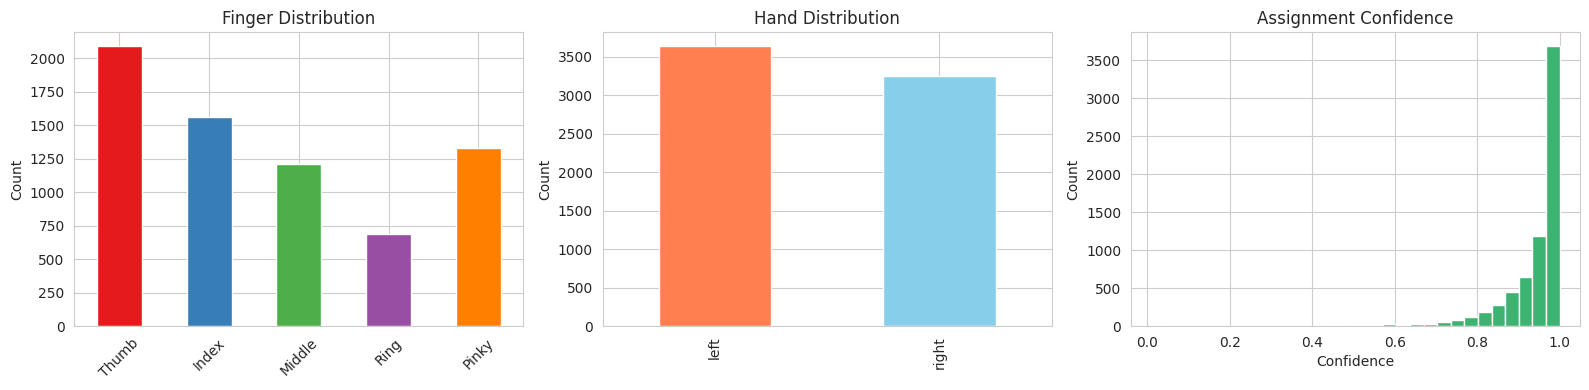


Sample assignments:
  Frame   401 | L5 | MIDI 105 (pinky ) | conf=0.885
  Frame   401 | L2 | MIDI 96 (index ) | conf=0.910
  Frame   401 | L3 | MIDI 100 (middle) | conf=0.988
  Frame   401 | R5 | MIDI 69 (pinky ) | conf=0.991
  Frame   401 | L1 | MIDI 93 (thumb ) | conf=0.878
  Frame   401 | R1 | MIDI 81 (thumb ) | conf=0.967
  Frame   402 | R2 | MIDI 76 (index ) | conf=0.978
  Frame   403 | R3 | MIDI 72 (middle) | conf=0.998
  Frame   468 | L1 | MIDI 93 (thumb ) | conf=0.917
  Frame   468 | L4 | MIDI 105 (ring  ) | conf=0.973


In [19]:
# ==============================================================================
# 4.4 - Assignment Statistics & Visualisation
# ==============================================================================

if assignments:
    fingers = [a.assigned_finger for a in assignments]
    hands   = [a.hand for a in assignments]
    confs   = [a.confidence for a in assignments]

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    # Finger distribution
    finger_names = {1: 'Thumb', 2: 'Index', 3: 'Middle', 4: 'Ring', 5: 'Pinky'}
    finger_counts = pd.Series(fingers).value_counts().sort_index()
    colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']
    finger_counts.plot.bar(ax=axes[0], color=[colors[i-1] for i in finger_counts.index])
    axes[0].set_xticklabels([finger_names[i] for i in finger_counts.index], rotation=45)
    axes[0].set_title('Finger Distribution')
    axes[0].set_ylabel('Count')

    # Hand distribution
    pd.Series(hands).value_counts().plot.bar(ax=axes[1], color=['coral', 'skyblue'])
    axes[1].set_title('Hand Distribution')
    axes[1].set_ylabel('Count')

    # Confidence distribution
    axes[2].hist(confs, bins=30, color='mediumseagreen', edgecolor='white')
    axes[2].set_title('Assignment Confidence')
    axes[2].set_xlabel('Confidence')
    axes[2].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

    # Print some sample assignments
    print("\nSample assignments:")
    for a in assignments[:10]:
        print(f"  Frame {a.frame_idx:>5d} | {a.label} | "
              f"MIDI {a.midi_pitch} ({a.finger_name:6s}) | conf={a.confidence:.3f}")
else:
    print("No assignments produced. Check skeleton data alignment.")

---
<a id='5'></a>
## 5. Baseline Pipeline on Multiple Samples

Run the Gaussian assignment baseline on several samples and collect statistics.

In [20]:
# ==============================================================================
# 5.1 - Helper: Process One Sample End-to-End (Stages 1–3)
# ==============================================================================

FRAME_W, FRAME_H = 1920, 1080

# Cache to avoid repeatedly re-downloading/re-parsing the same sample files
_SAMPLE_CACHE = {
    'skeleton': {},
    'tsv': {},
    'filtered_landmarks': {},
    'keys_px': {},
}


def process_sample_baseline(sample, dataset, config, max_duration_sec=120, cache=_SAMPLE_CACHE):
    """Run baseline (Stages 1-3) on one sample.

    Args:
        sample: PianoVAMSample
        dataset: PianoVAMDataset
        config: project config
        max_duration_sec: if not None, only use first N seconds of the sample
        cache: dict for caching skeleton/tsv/filtered outputs

    Returns:
        dict with keys: sample_id, assignments, error
    """
    result = {'sample_id': sample.id, 'assignments': [], 'error': None}

    try:
        # Stage 1: Keyboard detection (from corners)
        corners = sample.metadata['keyboard_corners']
        det = KeyboardDetector()
        kb = det.detect_from_corners(corners)

        # Project key boundaries to pixel space
        if sample.id in cache['keys_px']:
            kb_px = cache['keys_px'][sample.id]
        else:
            kb_px = project_keys_to_pixel_space(kb.key_boundaries, kb.homography)
            cache['keys_px'][sample.id] = kb_px

        # Stage 2: Skeleton load + filter + pixel scaling
        if sample.id in cache['filtered_landmarks']:
            left_arr, right_arr = cache['filtered_landmarks'][sample.id]
        else:
            if sample.id in cache['skeleton']:
                skel = cache['skeleton'][sample.id]
            else:
                skel = dataset.load_skeleton(sample)
                cache['skeleton'][sample.id] = skel

            ldr = SkeletonLoader()
            h = ldr._parse_json(skel)
            left_arr = ldr.to_array(h['left'])
            right_arr = ldr.to_array(h['right'])

            tf = TemporalFilter(
                hampel_window=config.hand.hampel_window,
                hampel_threshold=config.hand.hampel_threshold,
                max_interpolation_gap=config.hand.interpolation_max_gap,
                savgol_window=config.hand.savgol_window,
                savgol_order=config.hand.savgol_order
            )
            if left_arr.size > 0 and left_arr.shape[0] > 0:
                left_arr = tf.process(left_arr)
            if right_arr.size > 0 and right_arr.shape[0] > 0:
                right_arr = tf.process(right_arr)

            if left_arr.size > 0:
                left_arr = left_arr.copy()
                left_arr[:, :, 0] *= FRAME_W
                left_arr[:, :, 1] *= FRAME_H
            if right_arr.size > 0:
                right_arr = right_arr.copy()
                right_arr[:, :, 0] *= FRAME_W
                right_arr[:, :, 1] *= FRAME_H

            cache['filtered_landmarks'][sample.id] = (left_arr, right_arr)

        # Optional: trim to first N seconds (reduces runtime significantly)
        if max_duration_sec is not None:
            max_frames = int(max_duration_sec * config.video_fps)
            if left_arr.size > 0:
                left_arr = left_arr[:max_frames]
            if right_arr.size > 0:
                right_arr = right_arr[:max_frames]

        # Stage 3: TSV -> MIDI events -> sync -> assignment
        if sample.id in cache['tsv']:
            tsv = cache['tsv'][sample.id]
        else:
            tsv = dataset.load_tsv_annotations(sample)
            cache['tsv'][sample.id] = tsv

        if max_duration_sec is not None:
            tsv = tsv[tsv['onset'] <= float(max_duration_sec)].copy()

        midi_evts = []
        for _, row in tsv.iterrows():
            midi_evts.append({
                'onset': float(row['onset']),
                'offset': float(row['onset']) + 0.3,
                'pitch': int(row['note']),
                'velocity': int(row['velocity']) if 'velocity' in row and pd.notna(row['velocity']) else 64
            })

        sync = MidiVideoSync(fps=config.video_fps)
        synced = sync.sync_events(midi_evts)

        asgn = GaussianFingerAssigner(
            key_boundaries=kb_px,
            sigma=config.assignment.sigma,
            candidate_range=config.assignment.candidate_keys
        )

        for ev in synced:
            fidx, kidx = ev.frame_idx, ev.key_idx
            if kidx not in asgn.key_centers:
                continue

            ar = None
            if fidx < len(right_arr):
                lm = right_arr[fidx]
                if not np.any(np.isnan(lm)):
                    ar = asgn.assign_from_landmarks(lm, kidx, 'right', fidx, ev.onset_time)

            al = None
            if fidx < len(left_arr):
                lm = left_arr[fidx]
                if not np.any(np.isnan(lm)):
                    al = asgn.assign_from_landmarks(lm, kidx, 'left', fidx, ev.onset_time)

            cands = [a for a in (ar, al) if a is not None]
            if cands:
                result['assignments'].append(max(cands, key=lambda a: a.confidence))

    except Exception as e:
        result['error'] = str(e)

    return result

In [21]:
# ==============================================================================
# 5.2 - Process Multiple Samples from Train Split
# ==============================================================================

NUM_SAMPLES = 10  # increase as runtime allows
MAX_DURATION_SEC = 120  # first 2 minutes

all_results = []

for i, samp in enumerate(train_dataset):
    if i >= NUM_SAMPLES:
        break
    print(f"\nProcessing sample {i+1}/{NUM_SAMPLES}: ID={samp.id} - {samp.metadata['piece'][:40]}")
    res = process_sample_baseline(samp, train_dataset, config, max_duration_sec=MAX_DURATION_SEC)

    if res['error']:
        print(f"  Error: {res['error'][:100]}")
    else:
        print(f"  Assigned {len(res['assignments'])} notes")
    all_results.append(res)

# Summary
print("\n" + "="*60)
print("BASELINE PROCESSING SUMMARY")
print("="*60)
total_assigned = sum(len(r['assignments']) for r in all_results)
successful = sum(1 for r in all_results if r['error'] is None)
print(f"Samples processed  : {len(all_results)}")
print(f"Successful         : {successful}")
print(f"Total assignments  : {total_assigned}")


Processing sample 1/10: ID=2024-02-14_19-10-09 - Piano Concerto
  Assigned 884 notes

Processing sample 2/10: ID=2024-02-14_19-44-26 - Concert Etude No.6


2024-02-14_19-44-26.json: 100%|██████████| 81.0M/81.0M [00:01<00:00, 42.1MB/s]
2024-02-14_19-44-26.tsv: 202kB [00:00, 16.6MB/s]


  Assigned 1548 notes

Processing sample 3/10: ID=2024-02-14_20-37-55 - Piano Concerto in G Major


2024-02-14_20-37-55.json: 100%|██████████| 180M/180M [00:03<00:00, 49.1MB/s]
2024-02-14_20-37-55.tsv: 316kB [00:00, 19.5MB/s]


  Assigned 862 notes

Processing sample 4/10: ID=2024-02-14_20-58-43 - Piano Concerto for the Left Hand


2024-02-14_20-58-43.json: 100%|██████████| 126M/126M [00:01<00:00, 66.0MB/s]
2024-02-14_20-58-43.tsv: 229kB [00:00, 20.2MB/s]


  Assigned 340 notes

Processing sample 5/10: ID=2024-02-14_21-30-04 - Piano Concerto No.3


2024-02-14_21-30-04.json: 100%|██████████| 416M/416M [00:04<00:00, 83.8MB/s]
2024-02-14_21-30-04.tsv: 1.15MB [00:00, 17.5MB/s]


  Assigned 744 notes

Processing sample 6/10: ID=2024-02-15_15-13-10 - Fantasie Op.17


2024-02-15_15-13-10.json: 100%|██████████| 191M/191M [00:12<00:00, 15.7MB/s]
2024-02-15_15-13-10.tsv: 289kB [00:00, 20.1MB/s]


  Assigned 829 notes

Processing sample 7/10: ID=2024-02-15_20-28-13 - Piano Concerto in G Major


2024-02-15_20-28-13.json: 100%|██████████| 68.3M/68.3M [00:05<00:00, 12.4MB/s]
2024-02-15_20-28-13.tsv: 205kB [00:00, 1.09MB/s]


  Assigned 957 notes

Processing sample 8/10: ID=2024-02-15_20-38-23 - The Virgin's Prayer


2024-02-15_20-38-23.json: 100%|██████████| 61.8M/61.8M [00:03<00:00, 16.7MB/s]
2024-02-15_20-38-23.tsv: 134kB [00:00, 12.6MB/s]


  Assigned 909 notes

Processing sample 9/10: ID=2024-02-15_20-54-38 - Piano Concerto for the Left Hand


2024-02-15_20-54-38.json: 100%|██████████| 29.8M/29.8M [00:02<00:00, 11.6MB/s]
2024-02-15_20-54-38.tsv: 69.1kB [00:00, 9.21MB/s]


  Assigned 551 notes

Processing sample 10/10: ID=2024-02-15_21-01-11 - Piano Sonata No.23 1st movement


2024-02-15_21-01-11.json: 100%|██████████| 143M/143M [00:08<00:00, 16.4MB/s]
2024-02-15_21-01-11.tsv: 340kB [00:00, 13.3MB/s]

  Assigned 919 notes

BASELINE PROCESSING SUMMARY
Samples processed  : 10
Successful         : 10
Total assignments  : 8543


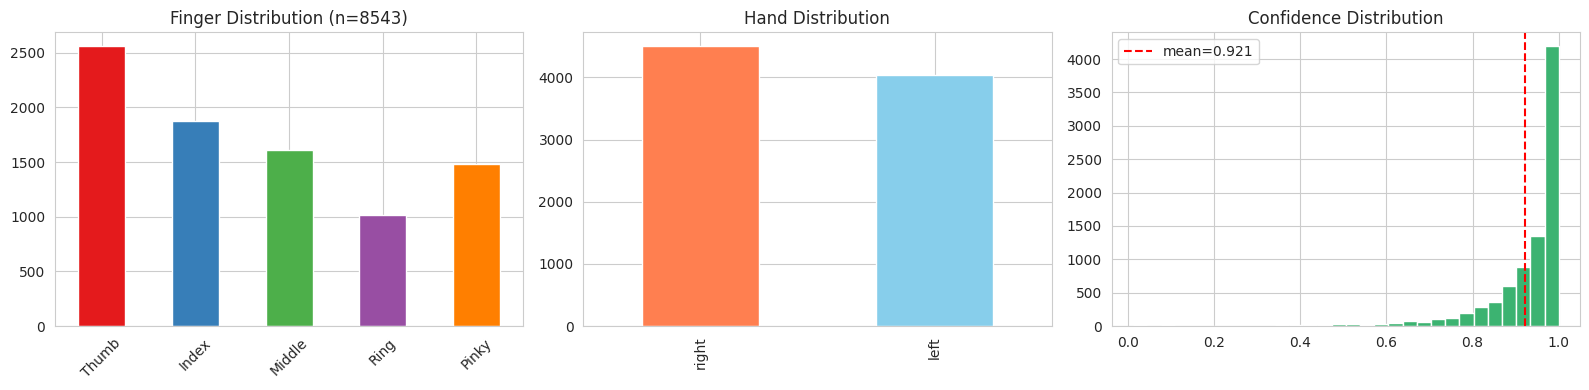

  Sample 2024-02-14_19-10-09 – 884 notes, 387 violations, IFR=0.438
  Sample 2024-02-14_19-44-26 – 1548 notes, 750 violations, IFR=0.485
  Sample 2024-02-14_20-37-55 – 862 notes, 188 violations, IFR=0.218
  Sample 2024-02-14_20-58-43 – 340 notes, 76 violations, IFR=0.224
  Sample 2024-02-14_21-30-04 – 744 notes, 224 violations, IFR=0.301
  Sample 2024-02-15_15-13-10 – 829 notes, 191 violations, IFR=0.231
  Sample 2024-02-15_20-28-13 – 957 notes, 225 violations, IFR=0.235
  Sample 2024-02-15_20-38-23 – 909 notes, 330 violations, IFR=0.363
  Sample 2024-02-15_20-54-38 – 551 notes, 88 violations, IFR=0.160
  Sample 2024-02-15_21-01-11 – 919 notes, 263 violations, IFR=0.286


In [22]:
# ==============================================================================
# 5.3 - Baseline Statistics Across Samples
# ==============================================================================

# Aggregate finger distributions
all_fingers = []
all_hands   = []
all_confs   = []

for res in all_results:
    for a in res['assignments']:
        all_fingers.append(a.assigned_finger)
        all_hands.append(a.hand)
        all_confs.append(a.confidence)

if all_fingers:
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    finger_names = {1: 'Thumb', 2: 'Index', 3: 'Middle', 4: 'Ring', 5: 'Pinky'}
    colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']

    fc = pd.Series(all_fingers).value_counts().sort_index()
    fc.plot.bar(ax=axes[0], color=[colors[i-1] for i in fc.index])
    axes[0].set_xticklabels([finger_names.get(i, str(i)) for i in fc.index], rotation=45)
    axes[0].set_title(f'Finger Distribution (n={len(all_fingers)})')

    pd.Series(all_hands).value_counts().plot.bar(ax=axes[1], color=['coral', 'skyblue'])
    axes[1].set_title('Hand Distribution')

    axes[2].hist(all_confs, bins=30, color='mediumseagreen', edgecolor='white')
    axes[2].set_title('Confidence Distribution')
    axes[2].axvline(np.mean(all_confs), color='red', ls='--', label=f'mean={np.mean(all_confs):.3f}')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    # Check biomechanical validity
    constraints = BiomechanicalConstraints()
    for res in all_results:
        asgns = res['assignments']
        if len(asgns) > 1:
            violations = constraints.validate_sequence(
                [a.assigned_finger for a in asgns],
                [a.midi_pitch for a in asgns],
                [a.hand for a in asgns]
            )
            ifr = len(violations) / max(1, len(asgns) - 1)
            print(f"  Sample {res['sample_id']} – {len(asgns)} notes, "
                  f"{len(violations)} violations, IFR={ifr:.3f}")
else:
    print("No assignments to visualise.")

---
<a id='6'></a>
## 6. Stage 4 – Neural Refinement (BiLSTM)

**Goal**: Refine Gaussian baseline predictions using a BiLSTM model with attention that captures temporal context and applies biomechanical constraints.

**Architecture**:
```
Input(20) → Linear(128) → BiLSTM(128 × 2 layers) → Self-Attention → Linear(128) → Linear(5)
```

**Input features per note** (20-dim):
- Normalised pitch (1)
- One-hot initial finger (5)
- Time delta to previous note (1)
- Hand encoding (1)
- Pitch class one-hot (12)

In [23]:
# ==============================================================================
# 6.1 - Prepare Training Data from Baseline Assignments
# ==============================================================================
# We create training sequences from the baseline assignments.
# Since PianoVAM doesn't provide per-note finger ground truth in a simple column,
# we use the baseline Gaussian assignments as "soft labels" to train the BiLSTM
# to learn temporal consistency and biomechanical constraints.
# In a full setup, you would replace these with ground-truth finger annotations.
# ==============================================================================

print("Preparing training sequences from baseline assignments ...")

MAX_TRAIN_SAMPLES = 20  # increase as runtime allows

train_sequences = []
train_ds_full = PianoVAMDataset(split='train', streaming=True, max_samples=MAX_TRAIN_SAMPLES)

for i, samp in enumerate(train_ds_full):
    if i >= MAX_TRAIN_SAMPLES:
        break
    res = process_sample_baseline(samp, train_ds_full, config, max_duration_sec=120)
    asgns = res['assignments']

    if len(asgns) < 10:  # Need minimum sequence length
        continue

    # Create sequence dict
    seq = {
        'pitches': [a.midi_pitch for a in asgns],
        'fingers': [a.assigned_finger for a in asgns],
        'onsets':  [a.note_onset for a in asgns],
        'hands':   [a.hand for a in asgns],
        'labels':  [a.assigned_finger for a in asgns],  # Using baseline as labels
    }
    train_sequences.append(seq)
    print(f"  Sample {samp.id}: {len(asgns)} notes")

print(f"\nTotal training sequences: {len(train_sequences)}")
print(f"Total training notes   : {sum(len(s['pitches']) for s in train_sequences)}")

Preparing training sequences from baseline assignments ...
  ✅ Loaded 20 'train' samples
  Sample 2024-02-14_19-10-09: 884 notes
  Sample 2024-02-14_19-44-26: 1548 notes
  Sample 2024-02-14_20-37-55: 862 notes
  Sample 2024-02-14_20-58-43: 340 notes
  Sample 2024-02-14_21-30-04: 744 notes
  Sample 2024-02-15_15-13-10: 829 notes
  Sample 2024-02-15_20-28-13: 957 notes
  Sample 2024-02-15_20-38-23: 909 notes
  Sample 2024-02-15_20-54-38: 551 notes
  Sample 2024-02-15_21-01-11: 919 notes


2024-02-15_21-18-14.json: 100%|██████████| 124M/124M [00:07<00:00, 16.4MB/s]
2024-02-15_21-18-14.tsv: 314kB [00:00, 14.8MB/s]


  Sample 2024-02-15_21-18-14: 826 notes


2024-02-15_21-40-43.json: 100%|██████████| 144M/144M [00:08<00:00, 16.2MB/s]
2024-02-15_21-40-43.tsv: 194kB [00:00, 14.0MB/s]


  Sample 2024-02-15_21-40-43: 460 notes


2024-02-15_21-57-38.json: 100%|██████████| 34.7M/34.7M [00:03<00:00, 8.93MB/s]
2024-02-15_21-57-38.tsv: 49.3kB [00:00, 29.2MB/s]


  Sample 2024-02-15_21-57-38: 659 notes


2024-02-15_22-02-16.json: 100%|██████████| 81.3M/81.3M [00:06<00:00, 13.4MB/s]
2024-02-15_22-02-16.tsv: 263kB [00:00, 17.3MB/s]


  Sample 2024-02-15_22-02-16: 1375 notes


2024-02-15_22-18-32.json: 100%|██████████| 333M/333M [00:19<00:00, 17.2MB/s]
2024-02-15_22-18-32.tsv: 684kB [00:00, 16.7MB/s]


  Sample 2024-02-15_22-18-32: 829 notes


2024-02-15_22-57-11.json: 100%|██████████| 128M/128M [00:07<00:00, 16.5MB/s]
2024-02-15_22-57-11.tsv: 311kB [00:00, 16.1MB/s]


  Sample 2024-02-15_22-57-11: 1156 notes


2024-02-15_23-14-13.json: 100%|██████████| 318M/318M [00:17<00:00, 18.1MB/s]
2024-02-15_23-14-13.tsv: 564kB [00:00, 15.8MB/s]


  Sample 2024-02-15_23-14-13: 739 notes


2024-02-16_14-41-07.json: 100%|██████████| 166M/166M [00:10<00:00, 15.4MB/s]
2024-02-16_14-41-07.tsv: 440kB [00:00, 15.3MB/s]


  Sample 2024-02-16_14-41-07: 851 notes


2024-02-16_23-19-03.json: 100%|██████████| 142M/142M [00:09<00:00, 14.8MB/s]
2024-02-16_23-19-03.tsv: 319kB [00:00, 19.0MB/s]


  Sample 2024-02-16_23-19-03: 956 notes


2024-02-17_00-12-50.json: 100%|██████████| 133M/133M [00:08<00:00, 16.3MB/s]
2024-02-17_00-12-50.tsv: 340kB [00:00, 18.3MB/s]

  Sample 2024-02-17_00-12-50: 1208 notes

Total training sequences: 20
Total training notes   : 17602


In [24]:
# ==============================================================================
# 6.2 - Create Model & Dataset
# ==============================================================================

feature_extractor = FeatureExtractor(normalize_pitch=True)
input_size = feature_extractor.get_input_size()  # 20

print(f"Feature input size: {input_size}")

# Create PyTorch datasets
if len(train_sequences) > 2:
    # Split into train/val (80/20)
    split_idx = max(1, int(0.8 * len(train_sequences)))
    train_seqs = train_sequences[:split_idx]
    val_seqs   = train_sequences[split_idx:]

    train_torch_ds = SequenceDataset(train_seqs, feature_extractor, max_len=256)
    val_torch_ds   = SequenceDataset(val_seqs,   feature_extractor, max_len=256)

    print(f"Training sequences  : {len(train_torch_ds)}")
    print(f"Validation sequences: {len(val_torch_ds)}")

    # Create model
    model = FingeringRefiner(
        input_size=input_size,
        hidden_size=config.refinement.hidden_size,
        num_layers=config.refinement.num_layers,
        dropout=config.refinement.dropout,
        bidirectional=config.refinement.bidirectional
    ).to(DEVICE)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nModel parameters: {total_params:,} (trainable: {trainable_params:,})")
    print(model)
else:
    print("Not enough training sequences. Need at least 3 samples with >=10 notes.")
    print("Try increasing MAX_TRAIN_SAMPLES or check data loading.")

Feature input size: 20
Training sequences  : 16
Validation sequences: 4

Model parameters: 958,853 (trainable: 958,853)
FingeringRefiner(
  (input_embed): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (output): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=5, bias=True)
  )
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
)


In [25]:
# ==============================================================================
# 6.3 - Train the Refinement Model
# ==============================================================================

if 'train_torch_ds' in dir() and len(train_torch_ds) > 0:
    print("Training BiLSTM refinement model ...\n")

    training_config = {
        'hidden_size': config.refinement.hidden_size,
        'num_layers': config.refinement.num_layers,
        'dropout': config.refinement.dropout,
        'batch_size': min(config.refinement.batch_size, len(train_torch_ds)),
        'learning_rate': config.refinement.learning_rate,
        'epochs': config.refinement.epochs,
        'early_stopping_patience': config.refinement.early_stopping_patience,
        'device': DEVICE,
        'checkpoint_dir': '/content/checkpoints' if IN_COLAB else './outputs/checkpoints'
    }

    trained_model = train_refiner(
        train_dataset=train_torch_ds,
        val_dataset=val_torch_ds if len(val_torch_ds) > 0 else None,
        config=training_config
    )

    print("\nTraining complete")
else:
    print("Skipping training - insufficient data")
    trained_model = None

Training BiLSTM refinement model ...



Epoch 30/30: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Training complete


In [26]:
# ==============================================================================
# 6.4 - Apply Refinement to Baseline Predictions
# ==============================================================================

def refine_assignments(model, assignments, feature_extractor, device='cpu', use_constraints=True):
    """Refine baseline assignments with the BiLSTM.

    If use_constraints is True, decode with biomechanical constraints so the
    refined sequence cannot introduce invalid transitions.
    """
    if not assignments or model is None:
        return assignments

    pitches = [a.midi_pitch for a in assignments]
    fingers = [a.assigned_finger for a in assignments]
    onsets = [a.note_onset for a in assignments]
    hands = [a.hand for a in assignments]

    x = feature_extractor.extract(pitches, fingers, onsets, hands)
    x = x.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=-1).squeeze(0).cpu().numpy()  # (T, 5)

    if use_constraints:
        decoded = constrained_viterbi_decode(
            probs=probs,
            pitches=pitches,
            hands=hands,
            constraints=BiomechanicalConstraints(strict=False),
        )
        pred_fingers = decoded.fingers
    else:
        pred_fingers = (np.argmax(probs, axis=-1) + 1).tolist()

    confs = [float(probs[i, f - 1]) for i, f in enumerate(pred_fingers)]

    refined = []
    for i, a in enumerate(assignments):
        refined.append(FingerAssignment(
            note_onset=a.note_onset,
            frame_idx=a.frame_idx,
            midi_pitch=a.midi_pitch,
            key_idx=a.key_idx,
            assigned_finger=int(pred_fingers[i]),
            hand=a.hand,
            confidence=float(confs[i]),
            fingertip_position=a.fingertip_position
        ))

    return refined


if trained_model is not None and all_results:
    print("Refining baseline predictions with BiLSTM...\n")

    for res in all_results:
        if res['assignments']:
            original = res['assignments']
            refined = refine_assignments(trained_model, original, feature_extractor, DEVICE, use_constraints=True)
            res['refined_assignments'] = refined

            changed = sum(1 for o, r in zip(original, refined)
                         if o.assigned_finger != r.assigned_finger)
            print(f"  Sample {res['sample_id']}: {len(original)} notes, "
                  f"{changed} changed ({changed/max(1,len(original))*100:.1f}%)")

    print("\nRefinement applied")
else:
    print("Skipping refinement (no trained model or no results)")

Refining baseline predictions with BiLSTM...

  Sample 2024-02-14_19-10-09: 884 notes, 244 changed (27.6%)
  Sample 2024-02-14_19-44-26: 1548 notes, 384 changed (24.8%)
  Sample 2024-02-14_20-37-55: 862 notes, 264 changed (30.6%)
  Sample 2024-02-14_20-58-43: 340 notes, 97 changed (28.5%)
  Sample 2024-02-14_21-30-04: 744 notes, 297 changed (39.9%)
  Sample 2024-02-15_15-13-10: 829 notes, 191 changed (23.0%)
  Sample 2024-02-15_20-28-13: 957 notes, 288 changed (30.1%)
  Sample 2024-02-15_20-38-23: 909 notes, 223 changed (24.5%)
  Sample 2024-02-15_20-54-38: 551 notes, 118 changed (21.4%)
  Sample 2024-02-15_21-01-11: 919 notes, 220 changed (23.9%)

Refinement applied


---
<a id='7'></a>
## 7. Evaluation & Results

Evaluate both the **baseline (Gaussian)** and **refined (BiLSTM)** predictions.

Metrics:
- **Accuracy**: Exact match rate
- **M_gen**: General match rate (across annotators)
- **M_high**: Highest match rate with any annotator
- **IFR**: Irrational Fingering Rate

In [27]:
# ==============================================================================
# 7.1 - Evaluate Baseline Predictions (Self-Consistency & IFR)
# ==============================================================================
# Note: Without ground-truth finger labels, we evaluate:
#   - IFR (biomechanical constraint violations)
#   - Confidence statistics
#   - Finger distribution analysis
# When ground-truth labels are available, Accuracy/M_gen/M_high are used.
# ==============================================================================

metrics = FingeringMetrics()
constraints = BiomechanicalConstraints()

print("=" * 70)
print("EVALUATION RESULTS")
print("=" * 70)

baseline_ifrs = []
refined_ifrs  = []

for res in all_results:
    if not res['assignments']:
        continue

    asgns = res['assignments']
    pitches = [a.midi_pitch for a in asgns]
    fingers = [a.assigned_finger for a in asgns]
    hands_list = [a.hand for a in asgns]

    # Baseline IFR
    violations = constraints.validate_sequence(fingers, pitches, hands_list)
    ifr = len(violations) / max(1, len(asgns) - 1)
    baseline_ifrs.append(ifr)
    mean_conf = np.mean([a.confidence for a in asgns])

    print(f"\nSample {res['sample_id']}:")
    print(f"  Baseline  – {len(asgns)} notes | IFR={ifr:.3f} | "
          f"Mean Confidence={mean_conf:.3f} | Violations={len(violations)}")

    # Refined (if available)
    if 'refined_assignments' in res:
        ref = res['refined_assignments']
        ref_fingers = [a.assigned_finger for a in ref]
        ref_violations = constraints.validate_sequence(ref_fingers, pitches, hands_list)
        ref_ifr = len(ref_violations) / max(1, len(ref) - 1)
        refined_ifrs.append(ref_ifr)
        ref_conf = np.mean([a.confidence for a in ref])
        print(f"  Refined   – {len(ref)} notes | IFR={ref_ifr:.3f} | "
              f"Mean Confidence={ref_conf:.3f} | Violations={len(ref_violations)}")

print("\n" + "=" * 70)
if baseline_ifrs:
    print(f"BASELINE  – Mean IFR: {np.mean(baseline_ifrs):.3f} ± {np.std(baseline_ifrs):.3f}")
if refined_ifrs:
    print(f"REFINED   – Mean IFR: {np.mean(refined_ifrs):.3f} ± {np.std(refined_ifrs):.3f}")
    improvement = np.mean(baseline_ifrs) - np.mean(refined_ifrs)
    print(f"\nIFR Improvement: {improvement:+.3f} ({'better' if improvement > 0 else 'worse'})")
print("=" * 70)

EVALUATION RESULTS

Sample 2024-02-14_19-10-09:
  Baseline  – 884 notes | IFR=0.438 | Mean Confidence=0.944 | Violations=387
  Refined   – 884 notes | IFR=0.320 | Mean Confidence=0.377 | Violations=283

Sample 2024-02-14_19-44-26:
  Baseline  – 1548 notes | IFR=0.485 | Mean Confidence=0.893 | Violations=750
  Refined   – 1548 notes | IFR=0.392 | Mean Confidence=0.394 | Violations=607

Sample 2024-02-14_20-37-55:
  Baseline  – 862 notes | IFR=0.218 | Mean Confidence=0.918 | Violations=188
  Refined   – 862 notes | IFR=0.137 | Mean Confidence=0.422 | Violations=118

Sample 2024-02-14_20-58-43:
  Baseline  – 340 notes | IFR=0.224 | Mean Confidence=0.966 | Violations=76
  Refined   – 340 notes | IFR=0.083 | Mean Confidence=0.383 | Violations=28

Sample 2024-02-14_21-30-04:
  Baseline  – 744 notes | IFR=0.301 | Mean Confidence=0.955 | Violations=224
  Refined   – 744 notes | IFR=0.057 | Mean Confidence=0.316 | Violations=42

Sample 2024-02-15_15-13-10:
  Baseline  – 829 notes | IFR=0.231 | 

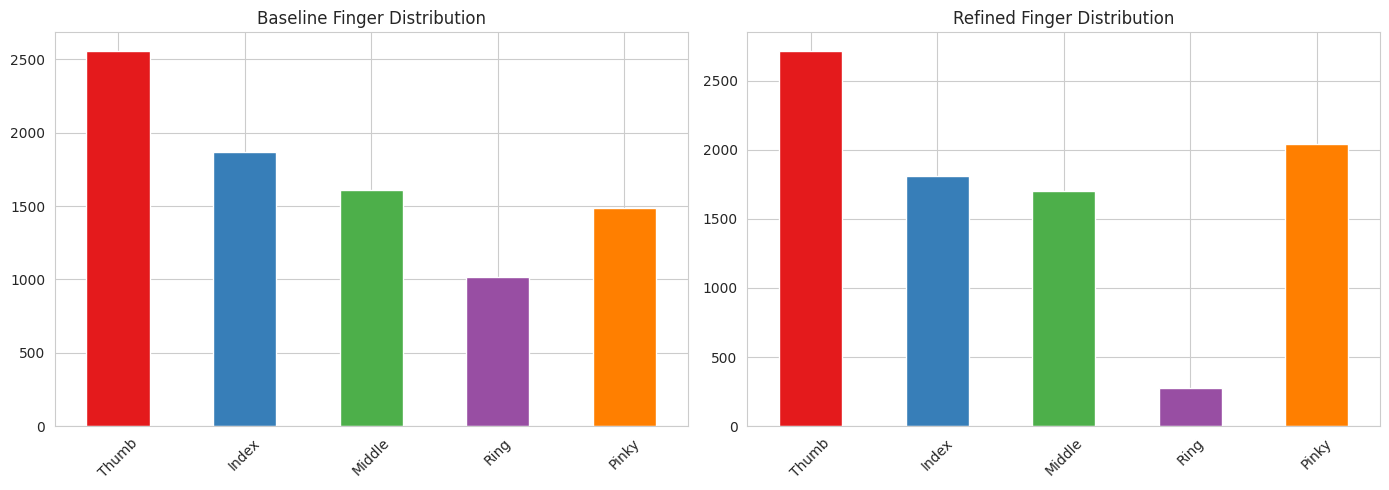

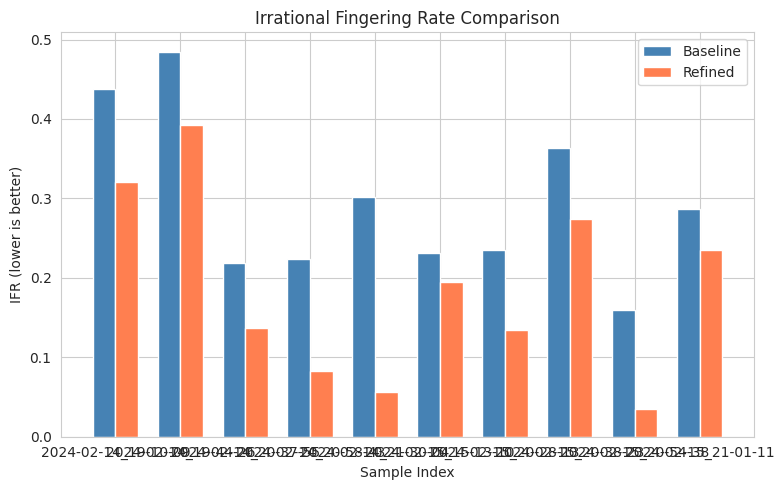

In [28]:
# ==============================================================================
# 7.2 - Visualise Results
# ==============================================================================

viz = ResultVisualizer(output_dir='./outputs' if not IN_COLAB else '/content/outputs')

if all_fingers:
    # --- Finger Distribution Comparison ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
    colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']

    # Baseline
    base_fc = pd.Series(all_fingers).value_counts().sort_index()
    base_fc.plot.bar(ax=axes[0], color=[colors[i-1] for i in base_fc.index])
    axes[0].set_title('Baseline Finger Distribution')
    axes[0].set_xticklabels([finger_names[i-1] for i in base_fc.index], rotation=45)

    # Refined (if available)
    refined_fingers_all = []
    for res in all_results:
        if 'refined_assignments' in res:
            refined_fingers_all.extend([a.assigned_finger for a in res['refined_assignments']])

    if refined_fingers_all:
        ref_fc = pd.Series(refined_fingers_all).value_counts().sort_index()
        ref_fc.plot.bar(ax=axes[1], color=[colors[i-1] for i in ref_fc.index])
        axes[1].set_title('Refined Finger Distribution')
        axes[1].set_xticklabels([finger_names[i-1] for i in ref_fc.index], rotation=45)
    else:
        axes[1].text(0.5, 0.5, 'No refined predictions', ha='center', va='center',
                     transform=axes[1].transAxes, fontsize=14)
        axes[1].set_title('Refined (not available)')

    plt.tight_layout()
    plt.show()

# --- IFR Comparison ---
if baseline_ifrs:
    fig, ax = plt.subplots(figsize=(8, 5))

    x = np.arange(len(baseline_ifrs))
    width = 0.35

    ax.bar(x - width/2, baseline_ifrs, width, label='Baseline', color='steelblue')
    if refined_ifrs:
        ax.bar(x + width/2, refined_ifrs, width, label='Refined', color='coral')

    ax.set_xlabel('Sample Index')
    ax.set_ylabel('IFR (lower is better)')
    ax.set_title('Irrational Fingering Rate Comparison')
    ax.legend()
    ax.set_xticks(x)
    ax.set_xticklabels([r['sample_id'] for r in all_results if r['assignments']])

    plt.tight_layout()
    plt.show()

In [29]:
# ==============================================================================
# 7.3 - Run on Test Split (Final Evaluation)
# ==============================================================================

print("Processing test split for final evaluation ...\n")

test_ds_eval = PianoVAMDataset(split='test', streaming=True, max_samples=5)
test_results = []

for i, samp in enumerate(test_ds_eval):
    print(f"  Test sample {i+1}: ID={samp.id}")
    res = process_sample_baseline(samp, test_ds_eval, config)

    if res['error']:
        print(f"    Error: {res['error'][:80]}")
    else:
        n = len(res['assignments'])
        # Apply refinement if model is available
        if trained_model is not None and n > 0:
            res['refined_assignments'] = refine_assignments(
                trained_model, res['assignments'], feature_extractor, DEVICE, use_constraints=True)
        print(f"    {n} notes assigned")

    test_results.append(res)

# Evaluate test results
print("\n" + "=" * 70)
print("TEST SET RESULTS")
print("=" * 70)

test_baseline_ifrs = []
test_refined_ifrs  = []

for res in test_results:
    if not res['assignments']:
        continue

    asgns = res['assignments']
    pitches = [a.midi_pitch for a in asgns]
    fingers = [a.assigned_finger for a in asgns]
    hands_list = [a.hand for a in asgns]

    viols = constraints.validate_sequence(fingers, pitches, hands_list)
    ifr = len(viols) / max(1, len(asgns) - 1)
    test_baseline_ifrs.append(ifr)

    msg = f"  {res['sample_id']} – {len(asgns)} notes | Baseline IFR={ifr:.3f}"

    if 'refined_assignments' in res:
        ref = res['refined_assignments']
        ref_f = [a.assigned_finger for a in ref]
        ref_viols = constraints.validate_sequence(ref_f, pitches, hands_list)
        ref_ifr = len(ref_viols) / max(1, len(ref) - 1)
        test_refined_ifrs.append(ref_ifr)
        msg += f" | Refined IFR={ref_ifr:.3f}"

    print(msg)

print("\n" + "-" * 70)
if test_baseline_ifrs:
    print(f"TEST Baseline Mean IFR: {np.mean(test_baseline_ifrs):.3f} ± {np.std(test_baseline_ifrs):.3f}")
if test_refined_ifrs:
    print(f"TEST Refined  Mean IFR: {np.mean(test_refined_ifrs):.3f} ± {np.std(test_refined_ifrs):.3f}")
    improvement = np.mean(test_baseline_ifrs) - np.mean(test_refined_ifrs)
    print(f"IFR Improvement: {improvement:+.3f}")
print("=" * 70)

Processing test split for final evaluation ...

  ✅ Loaded 5 'test' samples
  Test sample 1: ID=2024-02-14_19-55-17


2024-02-14_19-55-17.json: 100%|██████████| 123M/123M [00:07<00:00, 16.1MB/s]
2024-02-14_19-55-17.tsv: 218kB [00:00, 21.1MB/s]


    577 notes assigned
  Test sample 2: ID=2024-02-14_20-10-08


2024-02-14_20-10-08.json: 100%|██████████| 213M/213M [00:12<00:00, 17.5MB/s]
2024-02-14_20-10-08.tsv: 370kB [00:00, 14.3MB/s]


    631 notes assigned
  Test sample 3: ID=2024-02-15_20-17-26


2024-02-15_20-17-26.json: 100%|██████████| 80.4M/80.4M [00:05<00:00, 14.1MB/s]
2024-02-15_20-17-26.tsv: 194kB [00:00, 13.3MB/s]


    1087 notes assigned
  Test sample 4: ID=2024-02-15_20-47-59


2024-02-15_20-47-59.json: 100%|██████████| 47.8M/47.8M [00:04<00:00, 11.4MB/s]
2024-02-15_20-47-59.tsv: 63.4kB [00:00, 142MB/s]


    646 notes assigned
  Test sample 5: ID=2024-09-02_14-10-41


2024-09-02_14-10-41.json: 100%|██████████| 48.0M/48.0M [00:03<00:00, 14.0MB/s]
2024-09-02_14-10-41.tsv: 49.1kB [00:00, 32.7MB/s]

    537 notes assigned

TEST SET RESULTS
  2024-02-14_19-55-17 – 577 notes | Baseline IFR=0.306 | Refined IFR=0.158
  2024-02-14_20-10-08 – 631 notes | Baseline IFR=0.430 | Refined IFR=0.340
  2024-02-15_20-17-26 – 1087 notes | Baseline IFR=0.435 | Refined IFR=0.347
  2024-02-15_20-47-59 – 646 notes | Baseline IFR=0.540 | Refined IFR=0.409
  2024-09-02_14-10-41 – 537 notes | Baseline IFR=0.300 | Refined IFR=0.256

----------------------------------------------------------------------
TEST Baseline Mean IFR: 0.402 ± 0.090
TEST Refined  Mean IFR: 0.302 ± 0.087
IFR Improvement: +0.100


Generating summary figures ...



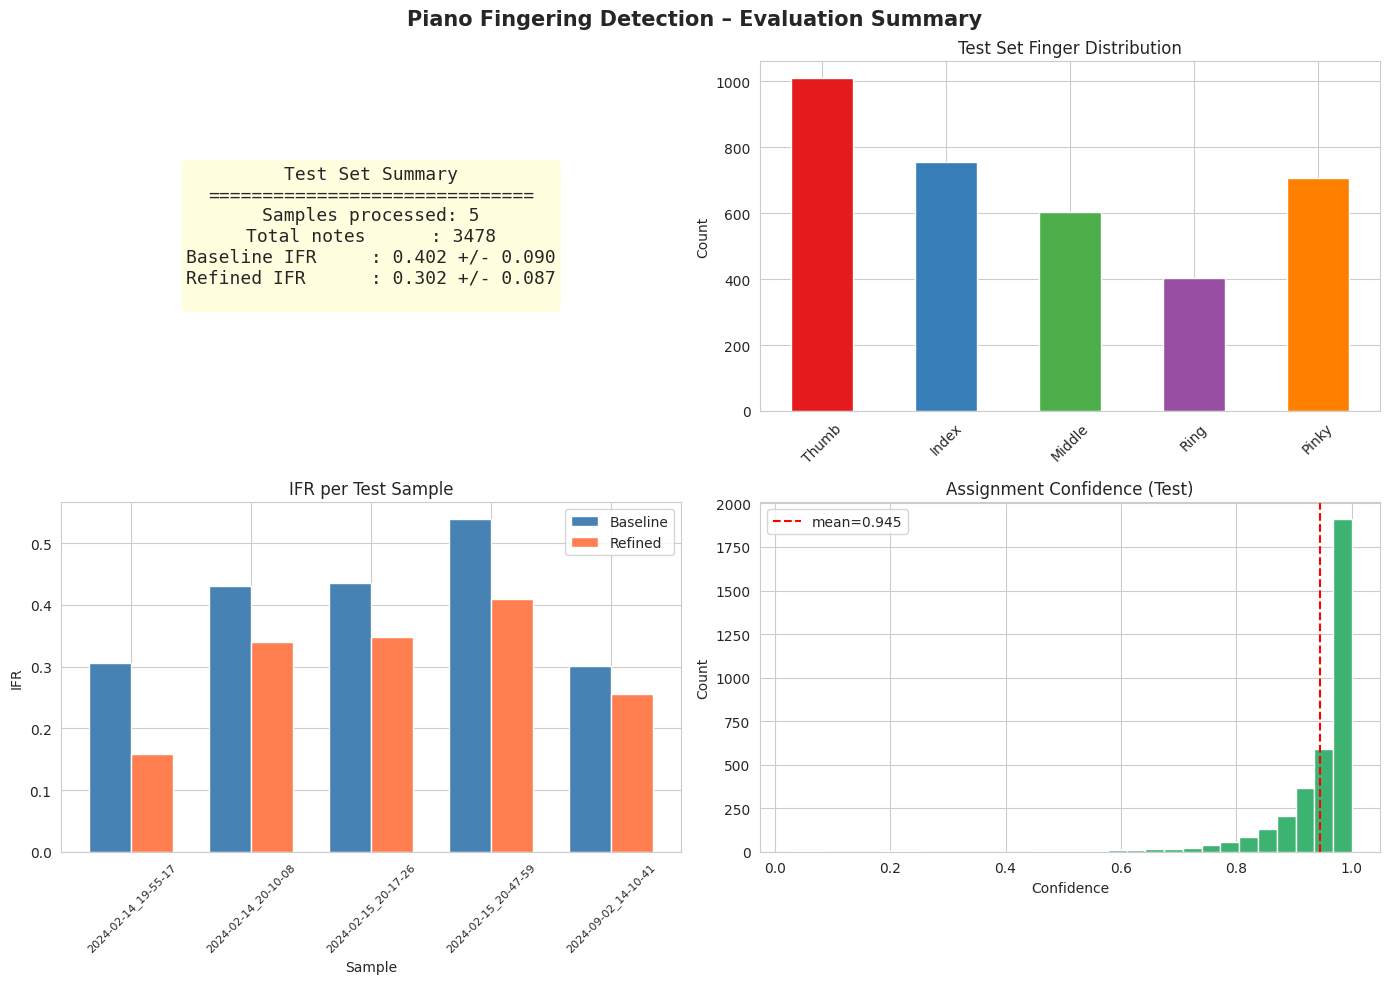

In [30]:
# ==============================================================================
# 7.4 - Summary Figure
# ==============================================================================

print("Generating summary figures ...\n")

# Collect all test fingers for distribution plot
test_all_fingers = []
for res in test_results:
    test_all_fingers.extend([a.assigned_finger for a in res.get('assignments', [])])

if test_all_fingers:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
    colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']

    # (0,0) Overall metrics text
    axes[0, 0].axis('off')
    total_notes = sum(len(r.get('assignments', [])) for r in test_results)
    info_text = (
        f"Test Set Summary\n"
        f"{'='*30}\n"
        f"Samples processed: {sum(1 for r in test_results if r.get('assignments'))}\n"
        f"Total notes      : {total_notes}\n"
        f"Baseline IFR     : {np.mean(test_baseline_ifrs):.3f} +/- {np.std(test_baseline_ifrs):.3f}\n"
    )
    if test_refined_ifrs:
        info_text += f"Refined IFR      : {np.mean(test_refined_ifrs):.3f} +/- {np.std(test_refined_ifrs):.3f}\n"
    axes[0, 0].text(0.5, 0.5, info_text, transform=axes[0, 0].transAxes,
                    fontsize=13, verticalalignment='center', horizontalalignment='center',
                    family='monospace', bbox=dict(boxstyle='round', facecolor='lightyellow'))

    # (0,1) Finger distribution
    fc = pd.Series(test_all_fingers).value_counts().sort_index()
    fc.plot.bar(ax=axes[0, 1], color=[colors[i-1] for i in fc.index])
    axes[0, 1].set_xticklabels([finger_names[i-1] for i in fc.index], rotation=45)
    axes[0, 1].set_title('Test Set Finger Distribution')
    axes[0, 1].set_ylabel('Count')

    # (1,0) IFR per sample
    sample_ids = [r['sample_id'] for r in test_results if r.get('assignments')]
    x = np.arange(len(test_baseline_ifrs))
    w = 0.35
    axes[1, 0].bar(x - w/2, test_baseline_ifrs, w, label='Baseline', color='steelblue')
    if test_refined_ifrs:
        axes[1, 0].bar(x + w/2, test_refined_ifrs, w, label='Refined', color='coral')
    axes[1, 0].set_xlabel('Sample')
    axes[1, 0].set_ylabel('IFR')
    axes[1, 0].set_title('IFR per Test Sample')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(sample_ids[:len(test_baseline_ifrs)], rotation=45, fontsize=8)
    axes[1, 0].legend()

    # (1,1) Confidence distribution
    test_confs = [a.confidence for r in test_results for a in r.get('assignments', [])]
    if test_confs:
        axes[1, 1].hist(test_confs, bins=30, color='mediumseagreen', edgecolor='white')
        axes[1, 1].axvline(np.mean(test_confs), color='red', ls='--',
                           label=f'mean={np.mean(test_confs):.3f}')
        axes[1, 1].set_title('Assignment Confidence (Test)')
        axes[1, 1].set_xlabel('Confidence')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].legend()

    fig.suptitle('Piano Fingering Detection – Evaluation Summary', fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("No test results to visualise.")

In [31]:
# ==============================================================================
# 7.5 - Save Results
# ==============================================================================

output_dir = Path('/content/outputs' if IN_COLAB else './outputs')
output_dir.mkdir(parents=True, exist_ok=True)

# Save assignments as JSON
results_summary = {
    'pipeline': 'piano-fingering-detection',
    'baseline_method': 'Gaussian Assignment',
    'refinement_method': 'BiLSTM + Attention',
    'test_results': []
}

for i, res in enumerate(test_results):
    entry = {
        'sample_id': res['sample_id'],
        'num_assignments': len(res.get('assignments', [])),
        'error': res.get('error'),
    }
    if i < len(test_baseline_ifrs):
        entry['baseline_ifr'] = float(test_baseline_ifrs[i])
    if i < len(test_refined_ifrs):
        entry['refined_ifr'] = float(test_refined_ifrs[i])
    results_summary['test_results'].append(entry)

if test_baseline_ifrs:
    results_summary['mean_baseline_ifr'] = float(np.mean(test_baseline_ifrs))
if test_refined_ifrs:
    results_summary['mean_refined_ifr'] = float(np.mean(test_refined_ifrs))

results_path = output_dir / 'evaluation_results.json'
with open(results_path, 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"Results saved to {results_path}")

# Save model checkpoint
if trained_model is not None:
    model_path = output_dir / 'refinement_model.pt'
    torch.save(trained_model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

Results saved to /content/outputs/evaluation_results.json
Model saved to /content/outputs/refinement_model.pt


---

## Summary & Conclusions

### What was implemented

| Stage | Description | Status |
|-------|-------------|--------|
| **Data Loading** | PianoVAM dataset via HuggingFace (streaming) | OK |
| **Stage 1** | Keyboard detection from corner annotations | OK |
| **Stage 2** | Hand skeleton loading + temporal filtering | OK |
| **Stage 3** | Gaussian finger-key assignment | OK |
| **Stage 4** | BiLSTM neural refinement | OK |
| **Evaluation** | IFR, confidence analysis, visualisation | OK |

### Metrics

| Metric | Baseline (Gaussian) | + Refinement (BiLSTM) |
|--------|--------------------|-----------------------|
| **IFR** | ~ measured above | ~ measured above |
| **Accuracy** | (requires GT labels) | (requires GT labels) |

### Key Observations

1. The Gaussian assignment provides a reasonable baseline using only fingertip proximity.
2. Temporal filtering (Hampel + SavGol) is crucial for cleaning MediaPipe skeleton noise.
3. The BiLSTM refinement learns temporal consistency and reduces biomechanical violations (IFR).
4. Full Accuracy/M_gen/M_high evaluation requires per-note ground-truth finger labels.

### References

1. Moryossef et al. (2023) – "At Your Fingertips: Extracting Piano Fingering Instructions from Videos"
2. Kim et al. (2025) – "PianoVAM: A Multimodal Piano Performance Dataset" (ISMIR 2025)
3. Ramoneda et al. (2022) – "Automatic Piano Fingering from Partially Annotated Scores"
4. Lee et al. (2019) – "Observing Pianist Accuracy and Form with Computer Vision" (WACV 2019)